In [105]:
import numpy as np  # 수치 연산 및 배열 처리를 위한 라이브러리
import pandas as pd  # 데이터 분석 및 DataFrame 처리를 위한 라이브러리
import requests  # HTTP 요청을 보내고 API 데이터를 가져오는 라이브러리
import folium  # 지도 시각화를 위한 라이브러리
import time

from tqdm.notebook import tqdm  # 코드 실행 중 진행 상태를 표시하는 진행 바
from bs4 import BeautifulSoup  # HTML/XML 데이터를 파싱하여 웹 크롤링을 수행하는 라이브러리

from selenium import webdriver  # 웹 브라우저 자동화를 위한 Selenium WebDriver 모듈
from selenium.webdriver.chrome.service import Service  # Chrome WebDriver 실행을 위한 서비스 클래스
from selenium.webdriver.common.by import By  # 웹 요소를 찾을 때 사용 (id, class, xpath 등)
from selenium.webdriver.support.ui import WebDriverWait  # 특정 요소가 나타날 때까지 대기하는 기능 제공
from selenium.webdriver.support import expected_conditions as EC  # 요소의 상태(로딩 완료, 클릭 가능 등)를 정의하는 조건 클래스

In [106]:
chrome_options = webdriver.ChromeOptions()  # Chrome 브라우저 옵션 설정 객체 생성
drive_path = 'chromedriver.exe'  # Chrome 드라이버 실행 파일 경로 지정
myservice = Service(drive_path)  # Chrome 드라이버 서비스를 실행할 Service 객체 생성
driver = webdriver.Chrome(service=myservice, options=chrome_options)  # Chrome 웹드라이버 객체 생성
print(type(driver))  # 생성된 드라이버 객체의 타입 출력

wait_time = 10  # 암시적 대기 시간(초) 설정
driver.implicitly_wait(wait_time)  # 웹 요소가 로드될 때까지 최대 10초 동안 대기

<class 'selenium.webdriver.chrome.webdriver.WebDriver'>


In [28]:
driver.maximize_window()  # 브라우저 창을 최대화

In [168]:
# 기상청 홈페이지 찾기
weather_url = 'https://search.naver.com/search.naver?where=nexearch&sm=top_hty&fbm=0&ie=utf8&query=%EC%84%9C%EC%9A%B8+%EB%82%A0%EC%94%A8'
driver.get(weather_url) #해당 페이지로 이동하시오.

naver_input_selector = '#nx_query'
naver_search_button_css = '#nx_search_form > fieldset > button > i'
regions = ['서울','부산','강릉']
for region in regions:
    WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, naver_input_selector))).clear()
    WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, naver_input_selector))).click()
    WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, naver_input_selector))).send_keys(f'{region} 날씨')
    WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, naver_search_button_css))).click()

    
    # 주간 날씨 HTML 코드를 파싱하여 html 파일에 기록합니다.
    html = driver.page_source
    filename = f'{region} 날씨 정보.html'
    htmlFile = open(filename, mode='wt', encoding='UTF-8')
    print(html, file=htmlFile)
    print(filename + ' 파일 생성됨')
    soup = BeautifulSoup(html, 'html.parser')
    htmlFile.close()
    
    

    
    time.sleep(3) 

서울 날씨 정보.html 파일 생성됨
부산 날씨 정보.html 파일 생성됨
강릉 날씨 정보.html 파일 생성됨


In [198]:
from bs4 import BeautifulSoup
import pandas as pd

week_weather_list = []

# HTML 파일 열기
filename = "서울 날씨 정보.html"
with open(filename, mode='rt', encoding='UTF-8') as htmlFile:
    soup = BeautifulSoup(htmlFile, "html.parser")

# 'week_list' 안의 모든 'li' 태그 가져오기 (날짜별 날씨 정보)
day_week_weather_list = soup.find("ul", class_="week_list").find_all("li")

for day_soup in tqdm(day_week_weather_list):
    # 날짜 및 요일 정보 가져오기
    date = day_soup.find("span", class_="date").text.strip()
    day_of_the_week = day_soup.find("strong", class_="day").text.strip()

    # 오전 및 오후 날씨 정보 가져오기
    am_weather = day_soup.select_one(".weather_inner:nth-of-type(1) .blind").text.strip()
    pm_weather = day_soup.select_one(".weather_inner:nth-of-type(2) .blind").text.strip()

    # 오전 및 오후 강수 확률 가져오기
    am_chance_of_precipitation = day_soup.select_one(".weather_inner:nth-of-type(1) .rainfall").text.strip()
    pm_chance_of_precipitation = day_soup.select_one(".weather_inner:nth-of-type(2) .rainfall").text.strip()

    # 최저 및 최고 기온 가져오기
    temperature = day_soup.find("span", class_="lowest").text.replace("최저기온", "").strip()
    highest_temperature = day_soup.find("span", class_="highest").text.replace("최고기온", "").strip()

    # 리스트에 추가
    week_weather_list.append([
        date, day_of_the_week, am_weather, pm_weather,
        am_chance_of_precipitation, pm_chance_of_precipitation,
        temperature, highest_temperature
    ])

# DataFrame으로 변환하여 출력
df = pd.DataFrame(week_weather_list, columns=[
    "날짜", "요일", "오전 날씨", "오후 날씨", 
    "오전 강수확률", "오후 강수확률", "최저 기온", "최고 기온"
])
df



  0%|          | 0/10 [00:00<?, ?it/s]

,날짜,요일,오전 날씨,오후 날씨,오전 강수확률,오후 강수확률,최저 기온,최고 기온
0,3.12.,오늘,흐림,구름많고 가끔 비,30%,60%,6°,11°
1,3.13.,내일,맑음,구름많음,0%,20%,3°,14°
2,3.14.,금,구름많음,구름많음,10%,20%,3°,17°
3,3.15.,토,구름많음,흐림,20%,30%,6°,15°
4,3.16.,일,흐리고 비/눈,흐리고 비/눈,60%,70%,3°,7°
5,3.17.,월,맑음,구름많음,20%,20%,-1°,7°
6,3.18.,화,흐리고 비/눈,흐리고 비/눈,60%,60%,0°,8°
7,3.19.,수,구름많음,맑음,20%,10%,0°,8°
8,3.20.,목,맑음,맑음,10%,10%,0°,11°
9,3.21.,금,맑음,맑음,10%,10%,2°,13°


<html data-platform="win32" data-useragent="mozilla/5.0 (windows nt 10.0; win64; x64) applewebkit/537.36 (khtml, like gecko) chrome/134.0.0.0 safari/537.36" lang="ko"><head> <meta charset="utf-8"/> <meta content="always" name="referrer"/> <meta content="telephone=no,address=no,email=no" name="format-detection"/> <meta content="서울 날씨 : 네이버 검색" property="og:title"/> <meta content="https://ssl.pstatic.net/sstatic/search/common/og_v3.png" property="og:image"/> <meta content="'서울 날씨'의 네이버 검색 결과입니다." property="og:description"/> <meta content="'서울 날씨'의 네이버 검색 결과입니다." lang="ko" name="description"/> <title>서울 날씨 : 네이버 검색</title> <link href="https://ssl.pstatic.net/sstatic/search/favicon/favicon_32x32_240820.ico" rel="shortcut icon"/> <link href="https://ssl.pstatic.net/sstatic/search/opensearch-description.https.xml" rel="search" title="Naver" type="application/opensearchdescription+xml"/><script async="" src="https://ntm.pstatic.net/ex/nlog.js"></script><script async="" src="https://ntm.pstati
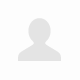
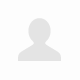
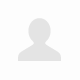
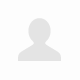

In [205]:
from bs4 import BeautifulSoup
import pandas as pd

def dosi_weather(dosi):
    week_weather_list = []  # 함수 내 지역 변수로 선언하여 중복 방지
    filename = f'{dosi} 날씨 정보.html'  # 도시 이름을 반영한 파일명
    try:
        with open(filename, mode='rt', encoding='UTF-8') as htmlFile:
            soup = BeautifulSoup(htmlFile, "html.parser")
            # print(soup)
        
        # 'week_list' 안의 모든 'li' 태그 가져오기 (날짜별 날씨 정보)
        day_week_weather_list = soup.find("ul", class_="week_list").find_all("li")

        for day_soup in day_week_weather_list:
            # 날짜 및 요일 정보 가져오기
            date = day_soup.find("span", class_="date").text.strip()
            day_of_the_week = day_soup.find("strong", class_="day").text.strip()

            # 오전 및 오후 날씨 정보 가져오기
            #구조 선택자 : 같은 태그와 클래스가 여러 개 존재할 때 사용한다.
            # .parent .child : .parent 안에 있는 .child를 찾음 (공백 있음)
            # .parent.child : .parent 클래스와 .child 클래스를 동시에 가지는 요소를 찾음 (공백 없음)
            am_weather = day_soup.select_one(".weather_inner:nth-of-type(1) .blind").text.strip() #weather_inner 클래스의 blind클래스인 첫번째 요소
            pm_weather = day_soup.select_one(".weather_inner:nth-of-type(2) .blind").text.strip() #weather_inner 클래스의 blind클래스인 두번째 요소

            # 오전 및 오후 강수 확률 가져오기
            am_chance_of_precipitation = day_soup.select_one(".weather_inner:nth-of-type(1) .rainfall").text.strip()
            pm_chance_of_precipitation = day_soup.select_one(".weather_inner:nth-of-type(2) .rainfall").text.strip()

            # 최저 및 최고 기온 가져오기
            temperature = day_soup.find("span", class_="lowest").text.replace("최저기온", "").strip()
            highest_temperature = day_soup.find("span", class_="highest").text.replace("최고기온", "").strip()

            # 리스트에 추가
            week_weather_list.append([
                dosi, date, day_of_the_week, am_weather, pm_weather,
                am_chance_of_precipitation, pm_chance_of_precipitation,
                temperature, highest_temperature
            ])

        # DataFrame으로 변환
        week_weather_frame = pd.DataFrame(week_weather_list, columns=[
            "도시", "날짜", "요일", "오전 날씨", "오후 날씨", 
            "오전 강수확률", "오후 강수확률", "최저 기온", "최고 기온"
        ])
        
        return week_weather_frame

    except FileNotFoundError:
        print(f"파일을 찾을 수 없습니다: {filename}")
        return None  # 파일이 없을 경우 None 반환

In [204]:
cities = ["서울", "부산", "강릉"]
for city in tqdm(cities):
    week_weather_frame = dosi_weather(city)
    display(week_weather_frame)
    #날씨 정보 csv 파일로 저장
    filename = f'{city}weatherFile.csv'
    # ediyaFrame.to_csv(filename, encoding='CP949', index=False) #index=False하면 행색인은 제외함. encoding='CP949'이 코드로 저장하면 엑셀로 볼 수 있음.
    week_weather_frame.to_csv(filename, encoding='UTF-8', index=False)
    print(filename + '파일 저장됨')

  0%|          | 0/3 [00:00<?, ?it/s]

,도시,날짜,요일,오전 날씨,오후 날씨,오전 강수확률,오후 강수확률,최저 기온,최고 기온
0,서울,3.12.,오늘,흐림,구름많고 가끔 비,30%,60%,6°,11°
1,서울,3.13.,내일,맑음,구름많음,0%,20%,3°,14°
2,서울,3.14.,금,구름많음,구름많음,10%,20%,3°,17°
3,서울,3.15.,토,구름많음,흐림,20%,30%,6°,15°
4,서울,3.16.,일,흐리고 비/눈,흐리고 비/눈,60%,70%,3°,7°
5,서울,3.17.,월,맑음,구름많음,20%,20%,-1°,7°
6,서울,3.18.,화,흐리고 비/눈,흐리고 비/눈,60%,60%,0°,8°
7,서울,3.19.,수,구름많음,맑음,20%,10%,0°,8°
8,서울,3.20.,목,맑음,맑음,10%,10%,0°,11°
9,서울,3.21.,금,맑음,맑음,10%,10%,2°,13°


서울weatherFile.csv파일 저장됨


,도시,날짜,요일,오전 날씨,오후 날씨,오전 강수확률,오후 강수확률,최저 기온,최고 기온
0,부산,3.12.,오늘,흐림,구름많고 가끔 비,30%,60%,6°,11°
1,부산,3.13.,내일,맑음,구름많음,0%,20%,3°,14°
2,부산,3.14.,금,구름많음,구름많음,10%,20%,3°,17°
3,부산,3.15.,토,구름많음,흐림,20%,30%,6°,15°
4,부산,3.16.,일,흐리고 비/눈,흐리고 비/눈,60%,70%,3°,7°
5,부산,3.17.,월,맑음,구름많음,20%,20%,-1°,7°
6,부산,3.18.,화,흐리고 비/눈,흐리고 비/눈,60%,60%,0°,8°
7,부산,3.19.,수,구름많음,맑음,20%,10%,0°,8°
8,부산,3.20.,목,맑음,맑음,10%,10%,0°,11°
9,부산,3.21.,금,맑음,맑음,10%,10%,2°,13°


부산weatherFile.csv파일 저장됨


,도시,날짜,요일,오전 날씨,오후 날씨,오전 강수확률,오후 강수확률,최저 기온,최고 기온
0,강릉,3.12.,오늘,구름많음,구름많음,20%,20%,8°,16°
1,강릉,3.13.,내일,구름많음,구름많음,20%,20%,7°,16°
2,강릉,3.14.,금,구름많음,맑음,20%,0%,7°,15°
3,강릉,3.15.,토,흐림,흐리고 비,30%,60%,8°,13°
4,강릉,3.16.,일,흐리고 비,흐리고 비,80%,60%,6°,11°
5,강릉,3.17.,월,구름많음,구름많음,20%,20%,1°,10°
6,강릉,3.18.,화,흐리고 비/눈,흐리고 비/눈,60%,70%,3°,11°
7,강릉,3.19.,수,구름많음,맑음,20%,10%,2°,10°
8,강릉,3.20.,목,맑음,맑음,10%,10%,2°,13°
9,강릉,3.21.,금,맑음,맑음,10%,10%,4°,14°


강릉weatherFile.csv파일 저장됨
